# Домашнее задание 4
***Когда-нибудь это закончится? Симуляция распространения болезни. Работа с NetworkX.***

**Цель**:
Перед вами не совсем стандартное домашнее задание, так как в нём практически не будет машинного обучения (если не считать анализа графов), но будет довольно много аналитики, симуляций, визуализаций и очень интересных выводов. Так как не совсем про ML, то и выполнять это задание не обязательно для успешного завершения курса. Но если вам интересно узнать, как можно смоделировать распространение инфекции по международной сети аэропортов, увидеть, как заражение аэропортов-хабов приводит к взрывному росту заболеваний и создать свой локальный Plague Inc., то давайте приступать :)


### Описание/Пошаговая инструкция выполнения домашнего задания:
Набор данных представляет собой основные маршруты авиаперелетов в США за один месяц 2008-го года. В качестве модели распространения инфекции предлагается использовать SI (susceptible-infected) модель, в которой каждый аэропорт имеет два возможных состояния - “здоровый” или “зараженный”. Здоровый аэропорт может заразиться с некоторой вероятностью p (infection probability), если к нему прилетает самолет из зараженного города. Инфекция начинает распространение из некоторого стартового аэропорта и заканчивает распространение, когда все перелеты из датасета завершены.

**1. Пишем симуляцию.**
Напишите функцию для симуляции одного прохода по всему датасету и распространения инфекции. Функция должна принимать на вход стартовый город, в котором изначально началась инфекция и вероятность распространения инфекции p. На выходе функция должна возвращать словарь, в котором ключом будет время заражения аэропорта, значением - название аэропорта. В теле функции вам нужно написать проход по всему датасету (имеет смысл использовать itertuples), где вы будете проверять, является ли текущий рейс “заразным” и если да - с вероятностью p заражать новый аэропорт.
В качестве стартовой ноды/аэропорта для симуляций можно использовать Allentown (node_id = 0).

**2. Как инфекционность (вероятность заражения) болезни влияет на скорость распространения?**
Давайте посмотрим, насколько заразной должна быть болезнь, чтобы заразить все аэропорты в сети. Для каждой из вероятностей p=[0.01, 0.05, 0.1, 0.5, 1.] прогоните по 10 симуляций распространения, каждый раз сохраняя результаты.
Для каждых 12 часов симуляции посчитайте, какой средний процент аэропортов от общего их числа, был заражен к этому моменту времени. Постройте графики числа зараженных городов в зависимости от времени для каждой из вероятностей.

**3. Может ли информация о сети помочь предсказать, кто будет заражен?**
Настало время поработать с NetworkX. По имеющемуся датасету вам нужно построить ненаправленный граф всех аэропортов, используя относительное число перелетов между соседними аэропортами в качестве веса ребра. Например, если из аэропорта А в аэропорт Б суммарно есть 5 рейсов, из Б в А 10 рейсов, а всего в сети 150 перелетов, то вес ребра между А и Б должен быть равен (5+10)/150 = 0.1.
Прогоните вашу симуляцию 50 раз, используя p=0.5 и стартовый аэропорт Allentown, каждый раз сохраняя результаты. Используя данные симуляций посчитайте медианное время до заражения каждого города.
Теперь используя построенный вами граф, для каждого города посчитайте его коэффициент кластеризации (nx.clustering), степень (nx.degree) и центральность (nx.betweenness_centrality).
Наконец, постройте scatter-plot-ы для медианного времени заражения и каждой из рассчитанных выше метрик. Также посчитайте коэффициент корреляции Спирмана между этими показателями и попробуйте проинтерпретировать полученные результаты. Какая из метрик графа сильнее всего скоррелирована со временем заражения? Почему?
https://www.kaggle.com/datasets/vikalpdongre/us-flights-data-2008

**Критерии оценки:**
<li>Если вы добрались до этой задачки - уже 2 балла.
<li>Написана работающая функция для симуляции - 2 балла.
<li>Протестировано влияние вероятности заражения на скорость распространения - 3 балла.
<li>Построены scatter-plot-ы метрик графа и медианного времени заражения + интерпретация результатов - 3 балла.

# Часть 1. Симуляция заражения

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('2008.csv')
df.head(3)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN


В симуляцию включим только вылетившие рейсы, т.к. в графе Cancelled стоит 1. Также использовать будем только столцы с датой, временем, пунктом отпраления и назначения по каждому рейсу.

Отсортируем полученный датасет по времени прилета. Вероятнее всего время локальное и желательно было бы привести его с универсальному формату, но для этой задачи сделаем предположение, что оно уже указано в едином формате.

In [2]:
df = df[df['Cancelled'] == 0]

columns_to_use = ['Year', 'Month', 'DayofMonth','CRSArrTime', 'Origin', 'Dest']

for column in columns_to_use:
    if df[column].isnull().sum() > 0:
        print(f'{column} contains {df[column].isnull().sum()} empty rows')

In [3]:
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

df['arr_date'] = df[['Year', 'Month', 'DayofMonth', 'CRSArrTime']].apply\
     (lambda df:datetime(df['Year'], df['Month'], df['DayofMonth'], 0 if int(df['CRSArrTime']//100) == 24 else int(df['CRSArrTime']//100), \
                         int(df['CRSArrTime']%100)), axis = 1)

In [4]:
df_fin = df[['Origin', 'Dest', 'arr_date']].sort_values(by  = 'arr_date')
df_fin

,Origin,Dest,arr_date
473954,TYS,DTW,2008-01-01 00:00:00
458190,TVC,DTW,2008-01-01 00:00:00
461695,SAV,DTW,2008-01-01 00:00:00
460486,CAE,DTW,2008-01-01 00:00:00
464259,IND,BDL,2008-01-01 00:00:00
...,...,...,...
6970742,BOS,PBI,2008-12-31 23:59:00
6930734,DFW,RDU,2008-12-31 23:59:00
6971932,SEA,EWR,2008-12-31 23:59:00
6923451,MIA,EWR,2008-12-31 23:59:00


In [5]:
print(f"Number of origin airports {df_fin['Origin'].nunique()}")
print(f"Number of destinations airports {df_fin['Dest'].nunique()}")

Number of origin airports 303
Number of destinations airports 304


Симуляция болезни будет работать следующим образом:

1. Для каждой строки в полученном датасете будет "подбрасываться кубик" с двумя гранями ('Infected', 'Not infected') с вероятностью, выбранной для решения задачи.

2. Аэропорт будет добавляться в список зараженных, если выпало 'Infected', а также пункт отправления заражен, а пункт назначения - нет и дата прибытия рейса позже даты начала эпидемии.

In [6]:
import random

def simulation(airport, start_date, probability, data):
    infected_airports = [airport]
    res = {start_date:airport}
    
    for indx, origin, dest, arr_date in data.itertuples():
        
        odds = random.choices(['Infected', 'Not infected'], weights=[probability, 1-probability])
        
        if (origin in infected_airports) and (dest not in infected_airports) and (odds == ['Infected'])\
                              and (arr_date >= datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S")):
            infected_airports.append(dest)
            res[arr_date] = dest
        else:
            continue
    
    return res                

# Часть 2. Запуск симуляции болезни

Далее запустим функцию симуляции для вероятностей p = [0.01, 0.05, 0.1, 0.5, 1] по 10 раз для каждой. Данные будем фиксировать каждые 12 часов с даты начала заражения. Полученные данные соберем в датафрейм, который будет включать среднее кол-во зараженных аэропортов по итогам 10 циклов на каждые 12 часов.

Старт симуляции - аэропорт в AllenTown NewYork. Дата начала симуляции будет 1 января. Полученные данные отразим на графиках.

In [7]:
from datetime import datetime, timedelta
from tqdm import tqdm_notebook

start_airport = 'ABE'
start_time = '2008-01-01 00:00:00'
p = [0.01, 0.05, 0.1, 0.5, 1]
n_runs = 10
measure_points = 365*2

res_fin = pd.DataFrame()

for probability in tqdm_notebook(p):
    tot_runs = pd.DataFrame()  
    for run in range(n_runs): 
        simulation_run = simulation(start_airport, start_time, probability, df_fin)
        temp = pd.DataFrame.from_dict(simulation_run, orient = 'index', columns = ['airport']).reset_index()
        temp['index'] = pd.to_datetime(temp['index'])
        temp1 = pd.DataFrame()
        temp1 = pd.DataFrame(data = {'date':[datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S")], f'prob_{probability}':[0]})
        
        start_point = (datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S"))
        for date in range(measure_points): # number of measure points  2 for each day
            start_point += timedelta(hours = 12)

            new_row = {'date': start_point,
                       #'run_id': f'{run}_{probability}',
                       f'prob_{probability}':len(temp[temp['index']<= start_point])
                      }
            temp1 = temp1.append(new_row, ignore_index = True)
        tot_runs = pd.concat([tot_runs, temp1])
    tot_runs = tot_runs.groupby('date')[f'prob_{probability}'].mean()
    res_fin = pd.concat([res_fin, tot_runs], axis = 1)
res_fin

  0%|          | 0/5 [00:00<?, ?it/s]

,prob_0.01,prob_0.05,prob_0.1,prob_0.5,prob_1
2008-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0
2008-01-01 12:00:00,1.0,1.1,15.1,102.3,119.0
2008-01-02 00:00:00,2.0,14.3,80.1,181.7,181.0
2008-01-02 12:00:00,2.6,30.8,95.5,189.5,182.0
2008-01-03 00:00:00,7.7,74.5,142.9,199.8,185.0
...,...,...,...,...,...
2008-12-29 00:00:00,290.0,281.3,267.2,227.0,207.0
2008-12-29 12:00:00,290.1,281.3,267.2,227.0,207.0
2008-12-30 00:00:00,290.1,281.3,267.2,227.0,207.0
2008-12-30 12:00:00,290.1,281.3,267.2,227.0,207.0


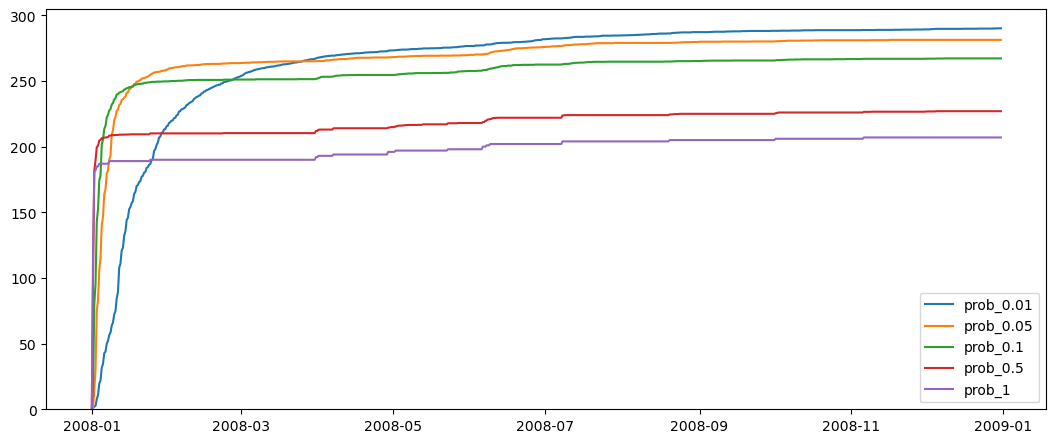

In [8]:
import matplotlib.pyplot as plt
fig =plt.figure(figsize = (10,4))
axes = fig.add_axes ([0,0,1,1])
axes.plot(res_fin['prob_0.01'], label = 'prob_0.01')
axes.plot(res_fin['prob_0.05'], label = 'prob_0.05')
axes.plot(res_fin['prob_0.1'], label = 'prob_0.1')
axes.plot(res_fin['prob_0.5'], label = 'prob_0.5')
axes.plot(res_fin['prob_1'], label = 'prob_1')
axes.set_ylim(ymin=0)
axes.legend()
plt.show()

## Комментарии к графикам:

Интересное наблюдение, что чем выше вероятность болезни, тем меньшее кол-во аэропортов заражается. При этом угол подъема (нарастания распространения инфекции) быстрее при более высоких вероятностях. На максимальные величины (плато) все графики выходят к концу 2-го месяца распространения болезни.

# Часть 3. Работа с графом

По данным рейсов построем **неориентированный, взвешенный граф:**

<li> sourсe -> аэропорт отправления
<li> target -> аэропорт назначения
<li> weight_% -> вес ребра (кол-во рейсов между source target + target source, деленное на общее кол-во рейсов) в процентах
    


    
 Подготовим промежуточный файл, а затем в нем подсчитаем вес для ребер графа.

In [9]:
nodes_temp = df_fin.copy()
nodes_temp['combo'] = nodes_temp[['Origin', 'Dest']].apply\
         (lambda nodes_temp: f"{nodes_temp['Origin']} {nodes_temp['Dest']}"\
            if nodes_temp['Origin'] < nodes_temp['Dest'] else f"{nodes_temp['Dest']} {nodes_temp['Origin']}", axis = 1)
nodes_temp

,Origin,Dest,arr_date,combo
473954,TYS,DTW,2008-01-01 00:00:00,DTW TYS
458190,TVC,DTW,2008-01-01 00:00:00,DTW TVC
461695,SAV,DTW,2008-01-01 00:00:00,DTW SAV
460486,CAE,DTW,2008-01-01 00:00:00,CAE DTW
464259,IND,BDL,2008-01-01 00:00:00,BDL IND
...,...,...,...,...
6970742,BOS,PBI,2008-12-31 23:59:00,BOS PBI
6930734,DFW,RDU,2008-12-31 23:59:00,DFW RDU
6971932,SEA,EWR,2008-12-31 23:59:00,EWR SEA
6923451,MIA,EWR,2008-12-31 23:59:00,EWR MIA


In [10]:
nodes = nodes_temp.groupby('combo').agg(tot_flights = ('combo', 'count'))
nodes = nodes.reset_index()
nodes['source'] = nodes['combo'].apply(lambda x: x.split(' ')[0])
nodes['target'] = nodes['combo'].apply(lambda x: x.split(' ')[1])
nodes['weight_%'] = nodes['tot_flights']/nodes['tot_flights'].sum()*100
nodes_fin = nodes[['source', 'target', 'weight_%']]
nodes_fin

,source,target,weight_%
0,ABE,ATL,0.024490
1,ABE,BHM,0.000015
2,ABE,CLE,0.023064
3,ABE,CLT,0.013373
4,ABE,CVG,0.007145
...,...,...,...
2822,STL,TPA,0.031489
2823,STL,TUL,0.025959
2824,SUN,TWF,0.000029
2825,SWF,TPA,0.006825


In [11]:
import networkx as nx
import sys

G = nx.from_pandas_edgelist(nodes_fin, 'source', 'target', 'weight_%')
sys.getsizeof(G)
print(f'Number of nodes {G.number_of_nodes()}')
print(f'Number of edges {G.number_of_edges()}')

Number of nodes 305
Number of edges 2827


Кол-во вершин графа отличается от кол-ва уникальных значений по рунткм отправления и назначения, это связано с тем, что есть аэропорты, в которые только есть рейсы отправления или прибытия.

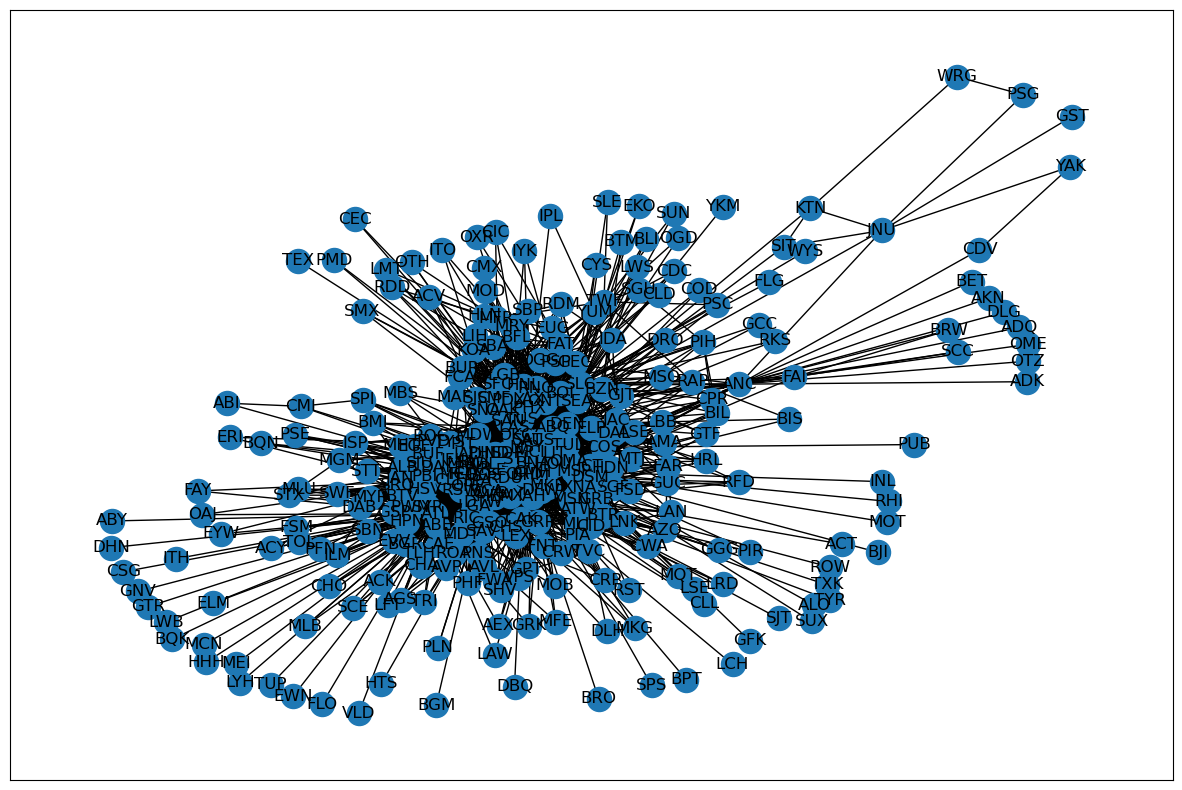

In [12]:
fig =plt.figure(figsize = (15,10))
nx.draw_networkx(G)

Графическое представление дает не особо много инофрмации: видно, что большая часто аэропортов очень тесно связана - больщой "клубок" в центре, есть часть аэропортов на отшибе. Посчитаем некоторые характерситики графа, чтобы больше понимать связи между узлами графа.

1. **Центральность (degree of centrality)** - чем больше соседей, тем выше значение.
2. **Степень посредничества (betweennes centrality)** - чем больше путей проходит через вершину, тем больше ее значение. Есть параметр weight, который интерпретируется как расстояние, поэтому все кол-ва рейсов, который мы используем в нашей задаче, на мой взгляд не подходит, оставим None как дефолт.
3. **Степень близости (closeness centrality)** - чем ближе к другим вершинам, тем выше.  
4. **Коэффициент кластеризации (clustering)** - обычный к-т показывает кол-во соседних вершин, взвешенный - с учетом веса ребер. Так как вес ребер в нашей задаче - это кол-во рейсов, то думаю имеет смысл использовать этот параметр, так как важны не только кол-во соседних аэропортов, но и кол-во рейсов.
5. **Степень вершины (degree)** - обычная показывает кол-во вершин, соседних с вершиной, взвешенная - с учетом веса. Для нашей задачи интересны оба показателя.

In [13]:
graph_stat = pd.DataFrame()

stat_list = [nx.degree_centrality(G), nx.betweenness_centrality(G),
            nx.closeness_centrality(G), nx.clustering(G, weight='weight_%')]
names = ['Degree_cent', 'Betw_cent', 'Clos_cent', 'Clust']

for name, stat in zip(names, stat_list):
    temp = stat
    graph_st = pd.DataFrame.from_dict(temp, orient = 'index', columns = [name])
    graph_stat = pd.concat([graph_stat, graph_st], axis = 1)

degrees = {node: val for (node, val) in G.degree()}
graph_st = pd.DataFrame.from_dict(degrees, orient = 'index', columns = ['Degrees'])
graph_stat = pd.concat([graph_stat, graph_st], axis = 1)

degrees_w = {node: val for (node, val) in G.degree(weight='weight_%')}
graph_st = pd.DataFrame.from_dict(degrees_w, orient = 'index', columns = ['Degrees_w'])
graph_stat = pd.concat([graph_stat, graph_st], axis = 1)

graph_stat.sort_values(by = ['Degree_cent', 'Betw_cent','Clos_cent', 
                             'Clust', 'Degrees', 'Degrees_w'], ascending = False)   
    

,Degree_cent,Betw_cent,Clos_cent,Clust,Degrees,Degrees_w
ATL,0.569079,0.201600,0.692483,0.023209,173,11.881025
ORD,0.493421,0.082999,0.658009,0.028167,150,9.744752
DFW,0.440789,0.102182,0.635983,0.029747,134,7.969595
MSP,0.417763,0.103724,0.626804,0.020507,127,3.738082
DEN,0.417763,0.067651,0.626804,0.030394,127,6.943882
...,...,...,...,...,...,...
BET,0.003289,0.000000,0.342342,0.000000,1,0.029335
ADQ,0.003289,0.000000,0.342342,0.000000,1,0.019353
ADK,0.003289,0.000000,0.342342,0.000000,1,0.002677
PUB,0.003289,0.000000,0.332968,0.000000,1,0.000029


In [14]:
print(f"Max degree centrality {graph_stat['Degree_cent'].idxmax()}")
print(f"Max between centrality {graph_stat['Betw_cent'].idxmax()}")
print(f"Max closeness centrality {graph_stat['Clos_cent'].idxmax()}")
print(f"Max clustering {graph_stat['Clust'].idxmax()}")
print(f"Max node degree {graph_stat['Degrees'].idxmax()}")
print(f"Max weighted node degree {graph_stat['Degrees_w'].idxmax()}")

Max degree centrality ATL
Max between centrality ATL
Max closeness centrality ATL
Max clustering LFT
Max node degree ATL
Max weighted node degree ATL


Практически по всем метрикам лидирует один аэропорт ATL в Нью-Йорке: у него больше всего направлений полетов, большее колво-рейсов проходит через него и он ближе к отсальным аэропортам. Ожидаемо, у этого аэропорта самый высокий показатель степени.
Интересно, что коэффициент кластеризации у него не самый высокий.

Далее посичтаем медианное время заражения для каждого аэропорта по 50 симуляцием. Время заражения - это разница между датой начала эпидемии и временем заражения аэропорта. Время переведм в часы и добавим в датафрейм с метриками для графа.

Посторим scatter plot для каждой метрики для оценки ее влияния на время заражения. Также выведем матрицу корреляции всех признаков.

In [15]:
start_airport = 'ABE'
start_time = '2008-01-01 00:00:00'

median = pd.DataFrame()
for run in tqdm_notebook(range(50)): 
    simulation_run = simulation(start_airport, start_time, 0.5, df_fin)
    temp = pd.DataFrame.from_dict(simulation_run, orient = 'index', columns = ['airport']).reset_index()
    temp = temp.set_index('airport')
    pos = temp.columns.get_loc('index')
    temp[f'run_{run}'] =  (temp.iloc[1:, pos] - temp.iat[0, pos])
    temp = temp.drop('index', axis = 1)
    median = pd.concat([median, temp], axis = 1)

median

  0%|          | 0/50 [00:00<?, ?it/s]

,run_0,run_1,run_2,run_3,run_4,run_5,run_6,run_7,run_8,run_9,...,run_40,run_41,run_42,run_43,run_44,run_45,run_46,run_47,run_48,run_49
airport,,,,,,,,,,,,,,,,,,,,,
ABE,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
ORD,0 days 08:34:00,0 days 08:34:00,NaT,NaT,0 days 08:34:00,0 days 08:20:00,0 days 08:34:00,0 days 08:34:00,NaT,0 days 08:19:00,...,0 days 08:19:00,0 days 08:19:00,NaT,NaT,0 days 08:34:00,NaT,0 days 08:54:00,0 days 08:34:00,NaT,0 days 08:34:00
HSV,0 days 08:45:00,0 days 08:45:00,0 days 08:29:00,NaT,0 days 08:45:00,NaT,NaT,NaT,0 days 08:29:00,NaT,...,NaT,0 days 09:40:00,NaT,NaT,0 days 08:45:00,NaT,0 days 11:10:00,NaT,0 days 17:13:00,NaT
CVG,0 days 08:50:00,0 days 09:54:00,0 days 08:25:00,0 days 09:14:00,NaT,NaT,0 days 09:44:00,0 days 08:50:00,0 days 08:21:00,NaT,...,0 days 08:25:00,0 days 08:13:00,0 days 08:13:00,NaT,0 days 09:53:00,NaT,0 days 08:16:00,0 days 08:50:00,0 days 12:21:00,NaT
MSN,0 days 08:52:00,0 days 09:26:00,0 days 08:52:00,0 days 11:20:00,0 days 09:26:00,0 days 08:52:00,0 days 08:52:00,0 days 12:28:00,0 days 09:26:00,0 days 11:20:00,...,0 days 08:52:00,0 days 11:20:00,NaT,0 days 11:20:00,0 days 11:20:00,0 days 13:15:00,0 days 09:26:00,0 days 09:26:00,0 days 11:20:00,0 days 09:26:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BNA,NaT,NaT,NaT,NaT,NaT,NaT,0 days 09:34:00,NaT,0 days 08:55:00,0 days 08:30:00,...,0 days 08:58:00,0 days 08:30:00,0 days 08:58:00,NaT,0 days 08:58:00,NaT,0 days 08:55:00,NaT,NaT,0 days 08:58:00
SJC,NaT,NaT,NaT,NaT,NaT,NaT,0 days 10:10:00,0 days 11:00:00,NaT,0 days 08:55:00,...,NaT,NaT,0 days 08:59:00,NaT,NaT,NaT,NaT,NaT,0 days 11:00:00,NaT
MHT,NaT,NaT,NaT,NaT,NaT,NaT,0 days 12:08:00,0 days 11:05:00,NaT,NaT,...,0 days 11:05:00,0 days 11:05:00,NaT,NaT,0 days 11:05:00,NaT,NaT,NaT,NaT,NaT


In [16]:
graph_stat = pd.concat([graph_stat, median.median(axis = 1)], axis = 1)
graph_stat = graph_stat.rename({0: 'Median_time'}, axis = 'columns')
graph_stat['Median_time'] = graph_stat['Median_time']/np.timedelta64(1,'h')
graph_stat.sort_values(by = ['Degree_cent', 'Betw_cent','Clos_cent', 
                             'Clust', 'Degrees', 'Degrees_w'], ascending = False)  

,Degree_cent,Betw_cent,Clos_cent,Clust,Degrees,Degrees_w,Median_time
ATL,0.569079,0.201600,0.692483,0.023209,173,11.881025,8.966667
ORD,0.493421,0.082999,0.658009,0.028167,150,9.744752,8.566667
DFW,0.440789,0.102182,0.635983,0.029747,134,7.969595,9.000000
MSP,0.417763,0.103724,0.626804,0.020507,127,3.738082,9.366667
DEN,0.417763,0.067651,0.626804,0.030394,127,6.943882,8.983333
...,...,...,...,...,...,...,...
BET,0.003289,0.000000,0.342342,0.000000,1,0.029335,20.066667
ADQ,0.003289,0.000000,0.342342,0.000000,1,0.019353,32.133333
ADK,0.003289,0.000000,0.342342,0.000000,1,0.002677,136.333333
PUB,0.003289,0.000000,0.332968,0.000000,1,0.000029,NaN


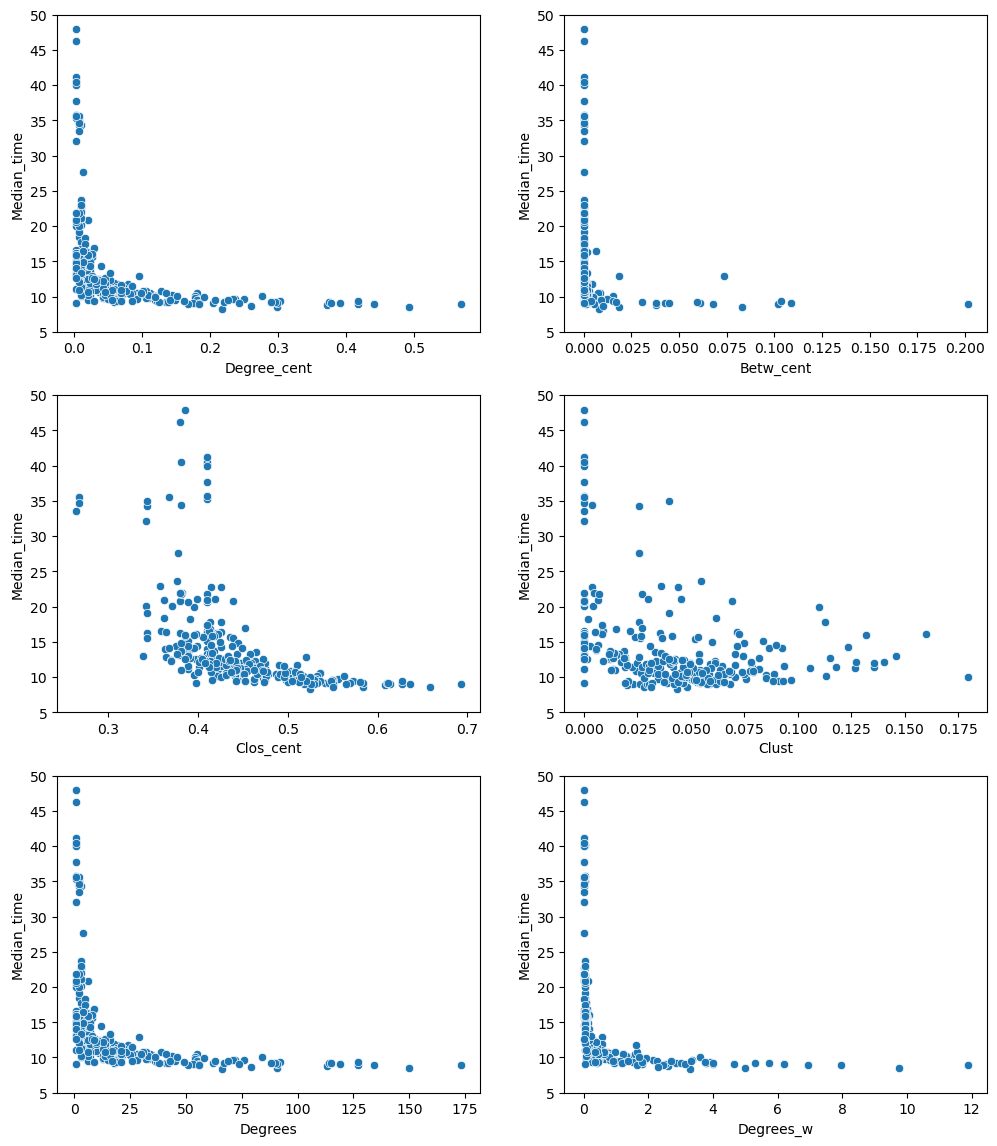

In [17]:
import seaborn as sns
features_for_plot = ['Degree_cent', 'Betw_cent', 'Clos_cent', 
                     'Clust', 'Degrees', 'Degrees_w']

plt.figure(figsize=[12, 14])
plt.tight_layout()
for i, feature in enumerate(features_for_plot):
    plt.subplot(3,2,i+1)
    plt.ylim(5,50)
    sns.scatterplot(y = graph_stat['Median_time'], x = graph_stat[feature])
    #plt.title(feature)

<AxesSubplot:>

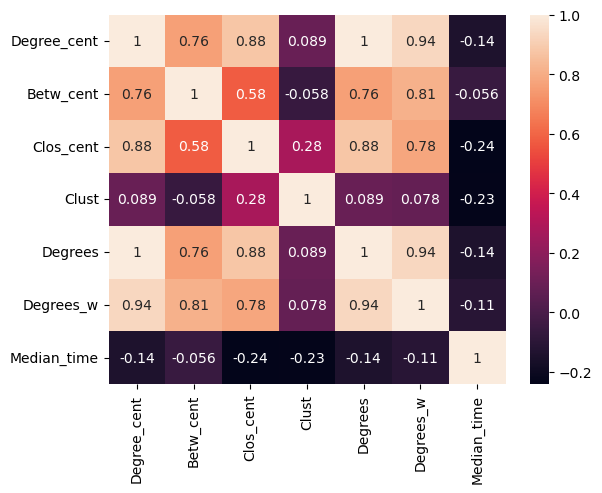

In [18]:
sns.heatmap(graph_stat.corr(method='pearson'), annot= True)

# Финальные выводы:

Итак, если рассматривать корреляцию метрик графа и среднего времени заражения, то наибольшая обратная корреляция у показателей степень близости и взвешенного коэффициента кластеризации. На диаграммах рассеивания можно даже рассмотреть что-то похожее на график гиперболы. В приницпе это ожидаемо, высокие величины этих метрик говорят о близости и высокой плотности вершин, что ускоряет распространение болезни.

Меньше всего корреляция времени заражения и степени посредничества, так как в случае с распространением инфекции быть промежуточным звеном не влияет на скорость распространения, важнее все-таки кол-во рейсов и направлений из зараженного аэропорта.

Если говорить о предсказании скорости заражения и возможных профилактических мерах, то в первую очередь основными "рассадниками заразы" будут те аэропорты, которые имеют высокую степень близости. Закрыв их на карантин, можно серьезно повлиять на распространение болезни.
